In [129]:
import pandas as pd
import numpy as np
import datetime

# group all by credit rating
# figure out price weighting (by market cap) for each day using normalization
# see how each segment performs

files = ['spx_daily_2.24.20_7.30.20.csv', 'spx_credit_rating_and_mkt_cap.csv']

#import the dataframes
spx_daily_prices = pd.read_csv(files[0], sep=',', index_col = 'DATES')
spx_credit_marketcap = pd.read_csv(files[1], sep=',', index_col = 'Security', header = 0,
                                  names = ['Security','Start_Rating', 'End_Rating', 'Market_Cap'],
                                   usecols = ['Security', 'Start_Rating', 'Market_Cap'],
                                  dtype = {'Start_Rating': 'str', 'Market_Cap':np.float64})

#convert prices index to datetime format
spx_daily_prices.index = pd.to_datetime(spx_daily_prices.index, format = '%m/%d/%Y')

# and change BBu and BBBu to BB and BBB (remove 'u') :
spx_credit_marketcap.loc[:,'Start_Rating'].replace('u$', '', regex=True, inplace=True)

#transpose prices to be able to match index
spx_daily_prices = spx_daily_prices.transpose()
spx_daily_prices.index.name = 'Security'

#sort both dataframes' indices alphabetically to be able to match them
spx_daily_prices.sort_index(inplace=True)
spx_credit_marketcap.sort_index(inplace=True)

#join credit df with prices df
spx_cred_prices = spx_credit_marketcap.join(spx_daily_prices, how = 'left')

#drop entries that are missing the credit rating
spx_cred_prices = spx_cred_prices.dropna(subset = ['Start_Rating'])


['BBB+' 'BBB-' 'A-' 'A' 'AA' 'A+' 'BB+' 'BBB' 'AA+' 'AAA' 'AA-' 'BB' nan
 'BB-' 'NR' 'B+' 'B']


In [172]:
#remove weekend dates for all groups
spx_cred_prices.dropna(axis=1, how='all', inplace=True)

# get each group's total market cap and turn it into a dictionary
#first groupby Start_Rating and sum the columns, then grab just the Market_Cap column (don't want sum of each date)
#turn it into a dictionary so you can use the map function
group_mktcaps = spx_cred_prices.groupby(by = ['Start_Rating'])['Market_Cap'].sum().to_dict()

#map takes a key and returns the value based on the 'mapped' dictionary
spx_cred_prices['Weight'] = spx_cred_prices['Market_Cap'].div(spx_cred_prices['Start_Rating'].map(group_mktcaps), axis = 0)

#normalize the daily price data by dividing each row by the price on the first date
#don't forget the -1 slicing to avoid changing the Weight column!
#need to keep the Start_Rating and Weight columns, so maintain the same variable
spx_cred_prices.iloc[:,2:-1] = spx_cred_prices.iloc[:,2:-1].div(spx_cred_prices.iloc[:,2], axis = 0)

#multiply each row by its weight 
# iloc[-1] because weight column is last. 
spx_cred_prices.iloc[:,2:-1] = spx_cred_prices.iloc[:,2:-1].mul(spx_cred_prices.iloc[:,-1], axis = 0)

#groupby the Start_Rating, sum it up, and multiply by 100
wtd_spx_bygroup = spx_cred_prices.groupby('Start_Rating')[spx_cred_prices.columns[2:-1]].sum().mul(100, axis = 0)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 112 entries, 2020-02-24 to 2020-07-31
Data columns (total 16 columns):
A       112 non-null float64
A+      112 non-null float64
A-      112 non-null float64
AA      112 non-null float64
AA+     112 non-null float64
AA-     112 non-null float64
AAA     112 non-null float64
B       112 non-null float64
B+      112 non-null float64
BB      112 non-null float64
BB+     112 non-null float64
BB-     112 non-null float64
BBB     112 non-null float64
BBB+    112 non-null float64
BBB-    112 non-null float64
NR      112 non-null float64
dtypes: float64(16)
memory usage: 19.9 KB
None


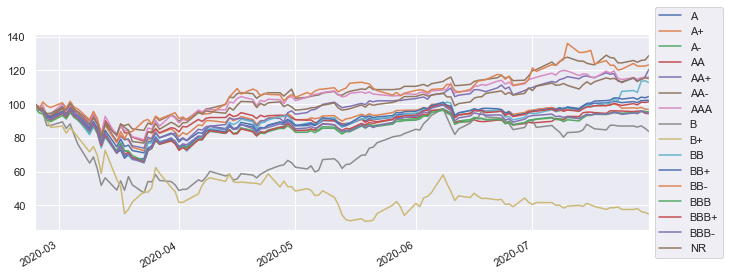

In [178]:
#let's try to plot this
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})

#transpose to make plotting easier (now each Column is a credit rating group)
wtd_spx_bygroupT = wtd_spx_bygroup.transpose()

#plot dat boi
final_graph = wtd_spx_bygroupT.plot().legend(loc='center left',bbox_to_anchor=(1.0, 0.5)).get_figure()
final_graph.savefig('test.pdf')

In [62]:
# NEXT THREE BOXES WERE JUST TRIAL AND ERROR TO FIGURE PROCESS OUT

# grab all the data for subset A to begin experimenting
group_A = spx_cred_prices[spx_cred_prices['Start_Rating'] == 'A']

#remove weekend dates without any price info

group_A.dropna(axis = 1, how = 'all', inplace = True)

#make a column for weighting
group_A['Weight'] = group_A['Market_Cap'].div(group_A['Market_Cap'].sum(), axis = 0)
print(group_A['Weight'].sum())
print(group_A.iloc[:, -1].sum())

1.0000000000000002
1.0000000000000002


/Users/nicolas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/nicolas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [66]:
#normalize the daily price data by dividing each row by the price on the first date
#don't forget the -1 slicing to avoid changing the weights!
group_A.iloc[:, 3:-1] = group_A.iloc[:, 3:-1].div(group_A.iloc[:,3], axis = 0)

#multiply each row by weight, sum it up to create the total index performance
# iloc[-1] because weight column is last. Here we multiply by Weight, sum it up, and multiply by 100  
wtd_group_A = group_A.iloc[:, 3:-1].mul(group_A['Weight'], axis = 0).sum().mul(100, axis = 0)


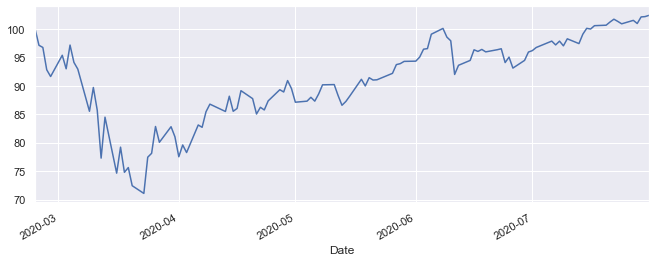

In [67]:
#let's try to plot this
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})
wtd_group_A.index.name = 'Date'
wtd_group_A.columns = ['Performance']
wtd_group_A.plot(x = 'Date', y = 'Performance')

